# Home Work 1


## Description.

Apply your knowledge about Fully-Connected NNs so far to solve several classification tasks


## Evaluation.

Along with every graded task you will see the maximum grading possible for it placed in (parenthesis). Grade might be lowered. The clear indicator that you won't get a maximum amount of points for a task is that your code does not work and/or your NN is not training. In order to obtain the maximum points you have to have sufficient accuracy >90%


### Good luck!

In [1]:
import numpy as np
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
import tqdm
import copy

In [4]:
!which python


/usr/local/bin/python


## Data

This is a toy dataset. <br>
$x \in \mathbb{R}^2, y \in \{0, 1\}$

In [5]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [6]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


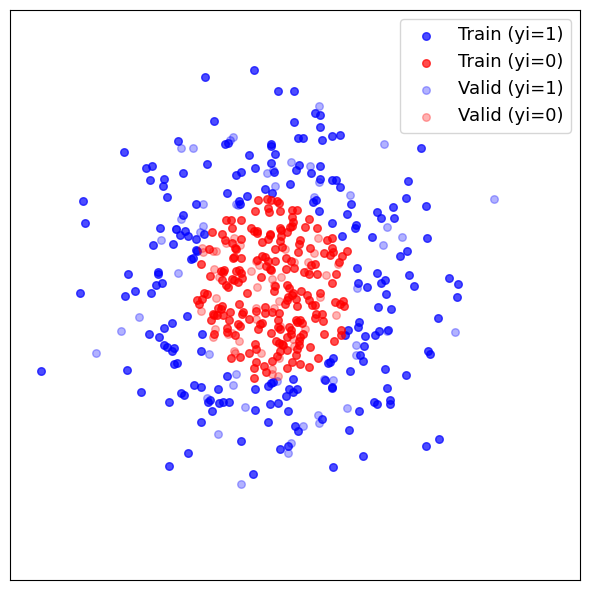

In [7]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## NN declaration (1 points)

You need to implement a class for a simple FC NN. Add as many layers and as many neurons as you'd like.

In [8]:
X_train.shape

(400, 2)

In [50]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.lay1 = nn.Linear(2, 64)
        self.act1 = nn.ReLU()
        self.lay2 = nn.Linear(64, 32)
        self.act2 = nn.ReLU()
        self.lay3 = nn.Linear(32, 16)
        self.act3 = nn.ReLU()
        self.lay4 = nn.Linear(16, 8)
        self.act4 = nn.ReLU()
        self.lay5 = nn.Linear(8, 1)
        self.sig = nn.Sigmoid()

    def forward(self, X):
        x = self.act1(self.lay1(X))
        x = self.act2(self.lay2(x))
        x = self.act3(self.lay3(x))
        x = self.act4(self.lay4(x))
        x = self.sig(self.lay5(x))
        return x

##  Train function. (1.5 points)
Add missing parts

In [88]:
def train(model, loss_fn, opt,
          n_epochs, batch_size,
          X_train, y_train, X_val=None, y_val=None):

    x_train_loader = DataLoader(X_train, batch_size=batch_size)
    y_train_loader = DataLoader(y_train, batch_size=batch_size)

    #x_val_ld = DataLoader(X_val, batch_size=1) if X_val is not None else None
    #y_val_ld = DataLoader(y_val, batch_size=1) if y_val is not None else None

    losses = []
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
    preds_history = []
    accuracies = []
    batch_start = torch.arange(0, len(X_train), batch_size)
    for epoch in range(n_epochs):

        model.train()
        loss_counter = 0

        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for x, y in zip(x_train_loader, y_train_loader):
                #forward
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                opt.zero_grad()
                loss.backward()
                opt.step()
                acc = (y_pred.round() == y).float().mean()
                loss_counter += float(loss)

                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
                bar.update(1)

        losses.append(loss_counter/batch_size)

        # evaluate accuracy at end of each epoch
        model.eval()

        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        accuracies.append(acc)

        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        if acc > 0.99:
            break
    # restore model and return best accuracy


    model.load_state_dict(best_weights)

    return (best_acc, losses, accuracies)

### Train the network. (1 point)

Train NN three times: with three different optimization algorithms. Don't forget to reinitialize model before each train. Make sure you pass the correct arguments to opt.

**Hint** It is better to have three different objects - model1, model2, and model3

In [12]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float().reshape(-1, 1)
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float().reshape(-1, 1)

In [89]:
model_1 = NeuralNetwork()
model_2 = NeuralNetwork()
model_3 = NeuralNetwork()


optims = {
          'Adam' : [optim.Adam(model_1.parameters(), lr=0.0001), model_1],
          'SGD' : [optim.SGD(model_2.parameters(), lr=0.01), model_2],
          'RMSprop' : [optim.RMSprop(model_3.parameters(), lr=0.000025), model_3]
}
loss = nn.BCELoss()
loss_list = []
acc_list = []
for opt_name, opt_and_model in optims.items():
    print("Optimizer name: ", opt_name)
    best, losses, accs = train(opt_and_model[1], loss, opt_and_model[0], 150, 10,
          X_train_torch, y_train_torch, X_valid_torch, y_valid_torch)
    print("Best accuracy: ", best)
    loss_list.append(losses)
    acc_list.append(accs)

Optimizer name:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


Epoch 67: 100%|██████████| 40/40 [00:00<00:00, 100.89batch/s, acc=1, loss=0.0493]


Best accuracy:  0.9900000095367432
Optimizer name:  SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


Epoch 98: 100%|██████████| 40/40 [00:00<00:00, 123.26batch/s, acc=1, loss=0.0378]


Best accuracy:  0.9900000095367432
Optimizer name:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 2.5e-05
    maximize: False
    momentum: 0
    weight_decay: 0
)


Epoch 149: 100%|██████████| 40/40 [00:00<00:00, 131.37batch/s, acc=1, loss=0.423]

Best accuracy:  0.9399999976158142


### А теперь посмотрим на графики лоссов

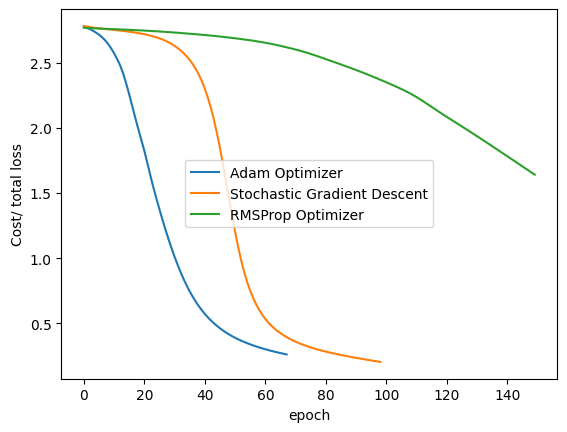

In [90]:
plt.plot(loss_list[0], label = "Adam Optimizer")
plt.plot(loss_list[1], label = "Stochastic Gradient Descent")
plt.plot(loss_list[2], label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

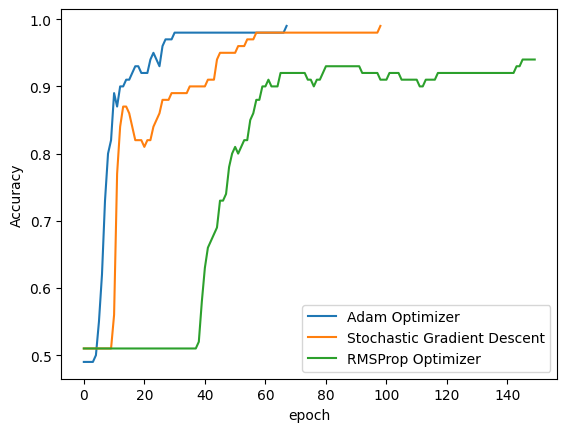

In [91]:
plt.plot(acc_list[0], label = "Adam Optimizer")
plt.plot(acc_list[1], label = "Stochastic Gradient Descent")
plt.plot(acc_list[2], label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [3]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_auc(y_test_true, y_test_pred_probs, y_train_true=None, y_train_pred_probs=None):
    """
    кастомная функция для отрисовки рок аука
    """
    if y_train_true is not None:
      fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_pred_probs)
      roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_pred_probs)
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(8, 6))

    if y_train_true is not None:
      plt.step(fpr_train, tpr_train, color='red', lw=1, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
      plt.fill_between(fpr_train, tpr_train, color='pink', alpha=0.75)

    plt.step(fpr_test, tpr_test, color='green', lw=1, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
    plt.fill_between(fpr_test, tpr_test, color='lightgreen', alpha=0.75)

    print("sds")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

sds


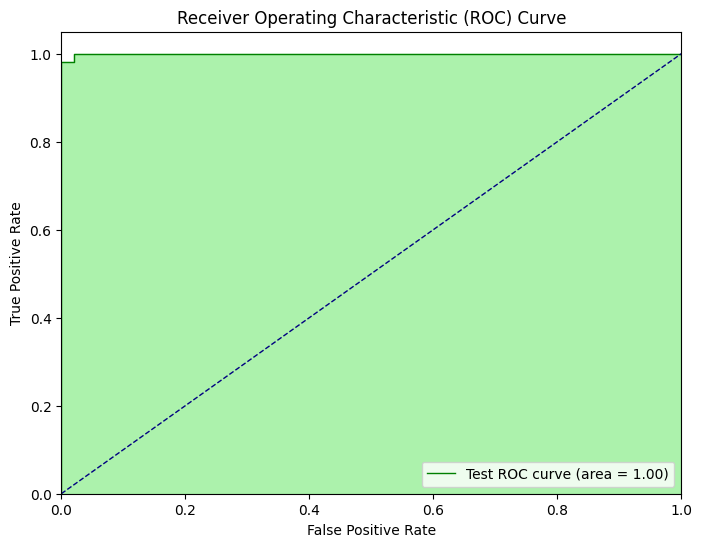

In [92]:
plot_roc_auc(y_valid_torch.detach().numpy(), model_1(X_valid_torch).detach().numpy())

## Now solve multi-class task (2.5 points)

You are welcome to use anything you know.


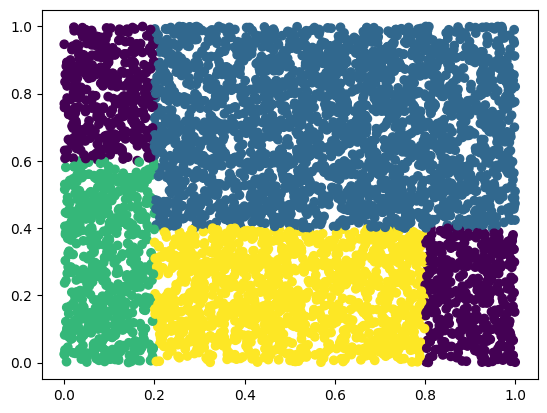

In [2]:
points = torch.rand(5000,2)
target = []
for p in points:
    if p[0]>0.2 and p[1]>0.4:
        target.append(1)
    elif p[0]<0.2 and p[1]<0.6:
        target.append(2)
    elif p[0]>0.2 and p[0]<0.8 and p[1] < 0.5:
        target.append(3)
    else:
        target.append(0)

target = torch.FloatTensor(target)
data = torch.as_tensor(np.column_stack((points,target)))

train = data[:800]
valid = data[800:900]
test = data[900:]

plt.scatter(data[:,0],data[:,1],c = data[:,2])
plt.show()

In [3]:
class AdvancedModel(nn.Module):
    def __init__(self):
        super(AdvancedModel, self).__init__()

        self.lay1 = nn.Linear(2, 128)
        self.act1 = nn.ReLU()

        self.lay2 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()

        self.lay3 = nn.Linear(64, 32)
        self.act3 = nn.ReLU()

        self.lay4 = nn.Linear(32, 16)
        self.act4 = nn.ReLU()

        self.lay5 = nn.Linear(16, 8)
        self.act5 = nn.ReLU()

        self.lay6 = nn.Linear(8, 4)

        self.dropout_2 = nn.Dropout(0.2)
        self.dropout_1 = nn.Dropout(0.1)

    def forward(self, x):
        x = self.act1(self.lay1(x))
        x = self.dropout_2(x)
        x = self.act2(self.lay2(x))
        x = self.dropout_2(x)
        x = self.act3(self.lay3(x))
        x = self.dropout_1(x)
        x = self.act4(self.lay4(x))
        x = self.act5(self.lay5(x))
        x = self.lay6(x)
        return x


In [4]:
def train_model(model, optim, loss_fn, n_epochs, batch_size,
                X_train, y_train, X_val, y_val):
  x_train_loader = DataLoader(X_train, batch_size=batch_size)
  y_train_loader = DataLoader(y_train, batch_size=batch_size)

  best_acc = - np.inf
  best_weights = None
  preds_history = []
  accuracies = []
  losses = []
  batch_start = torch.arange(0, len(X_train), batch_size)

  for epoch in range(n_epochs):
      model.train()
      loss_ctr = 0

      with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for x, y in zip(x_train_loader, y_train_loader):
          y_pred = model(x)
          loss = loss_fn(y_pred, y.long())

          loss_ctr += float(loss)

          optim.zero_grad()
          loss.backward()
          optim.step()

          acc = (torch.argmax(y_pred, dim=1) == y).float().mean()

          bar.set_postfix(
              loss = float(loss),
              acc = float(acc)
          )
          bar.update(1)

      losses.append(float(loss)/batch_size)

      model.eval()

      y_pred = model(X_val)
      acc = (torch.argmax(y_pred, dim=1) == y_val).float().mean()
      acc = float(acc)
      accuracies.append(float(acc))

      if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
      if acc > 0.99:
        break

  model.load_state_dict(best_weights)

  return (best_acc, losses, accuracies)

In [5]:
x_train = train[:,0:2]
y_train = train[:,2]

x_val = valid[:,0:2]
y_val = valid[:,2]

x_test = test[:,0:2]
y_test = test[:,2]

In [6]:
model_1 = AdvancedModel()
model_2 = AdvancedModel()
model_3 = AdvancedModel()


optims = {
          'Adam' : [optim.Adam(model_1.parameters(), lr=0.001), model_1],
          'SGD' : [optim.SGD(model_2.parameters(), lr=0.1), model_2],
          'RMSprop' : [optim.RMSprop(model_3.parameters(), lr=0.001), model_3]
}
loss = nn.CrossEntropyLoss()
loss_list = []
acc_list = []
for opt_name, opt_and_model in optims.items():
    print("Optimizer name: ", opt_name)
    best, losses, accs = train_model(opt_and_model[1], opt_and_model[0], loss, 100, 20,
          x_train, y_train, x_val, y_val)
    print("Best accuracy: ", best)
    loss_list.append(losses)
    acc_list.append(accs)

Optimizer name:  Adam


Epoch 33: 100%|██████████| 40/40 [00:00<00:00, 114.43batch/s, acc=1, loss=0.0443]


Best accuracy:  0.9900000095367432
Optimizer name:  SGD


Epoch 99: 100%|██████████| 40/40 [00:00<00:00, 121.03batch/s, acc=0.95, loss=0.123]


Best accuracy:  0.9800000190734863
Optimizer name:  RMSprop


Epoch 72: 100%|██████████| 40/40 [00:00<00:00, 109.11batch/s, acc=1, loss=0.0331]

Best accuracy:  0.9900000095367432


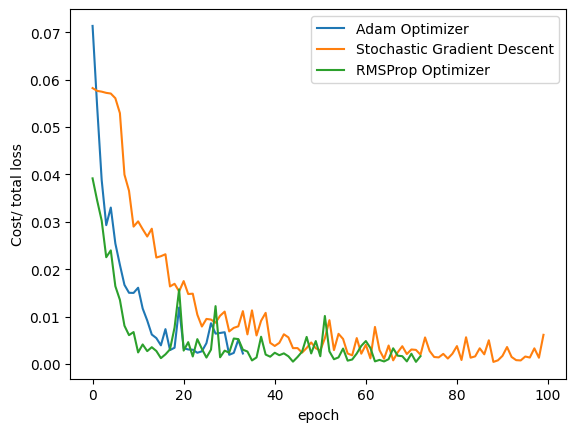

In [7]:
plt.plot(loss_list[0], label = "Adam Optimizer")
plt.plot(loss_list[1], label = "Stochastic Gradient Descent")
plt.plot(loss_list[2], label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

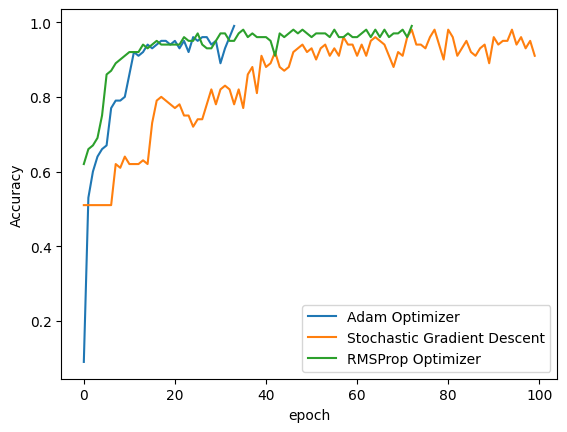

In [8]:
plt.plot(acc_list[0], label = "Adam Optimizer")
plt.plot(acc_list[1], label = "Stochastic Gradient Descent")
plt.plot(acc_list[2], label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
y_pred = model_1(x_test)
acc = (torch.argmax(y_pred, dim=1) == y_test).float().mean()
acc

tensor(0.9802)

In [10]:
y_pred = model_2(x_test)
acc = (torch.argmax(y_pred, dim=1) == y_test).float().mean()
acc

tensor(0.9741)

In [11]:
y_pred = model_3(x_test)
acc = (torch.argmax(y_pred, dim=1) == y_test).float().mean()
acc

tensor(0.9793)

## (Almost) Real task. (4 points)

This is alcohol classification task. You need to predict the target value.
Feel free to visualize and do whatever feels right to EDA and training model.
You can reuse previous models with slight changes or make a new one

In [12]:
df = sklearn.datasets.load_wine(as_frame=True)
df = df.frame
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [14]:
df['target'].unique()

array([0, 1, 2])

In [15]:
import seaborn as sns

In [16]:
def plots(data, name):

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  # Плотность распределения
  sns.kdeplot(data=data, fill = True, color='red', ax=axes[0])
  axes[0].set_title('Плотность распределения')

  # Ящик с усами
  sns.boxplot(data=data, ax=axes[1])
  axes[1].set_title('Ящик с усами')

  # Гистограмма
  sns.histplot(data=data, bins=50, color='red', ax=axes[2])
  axes[2].set_title('Гистограмма')

  fig.suptitle('Статистика признака {}'.format(name), fontsize=16)

  # Отображение графиков
  plt.tight_layout()
  plt.show()

In [69]:
names = iter(list(df.drop('target', axis=1).columns))

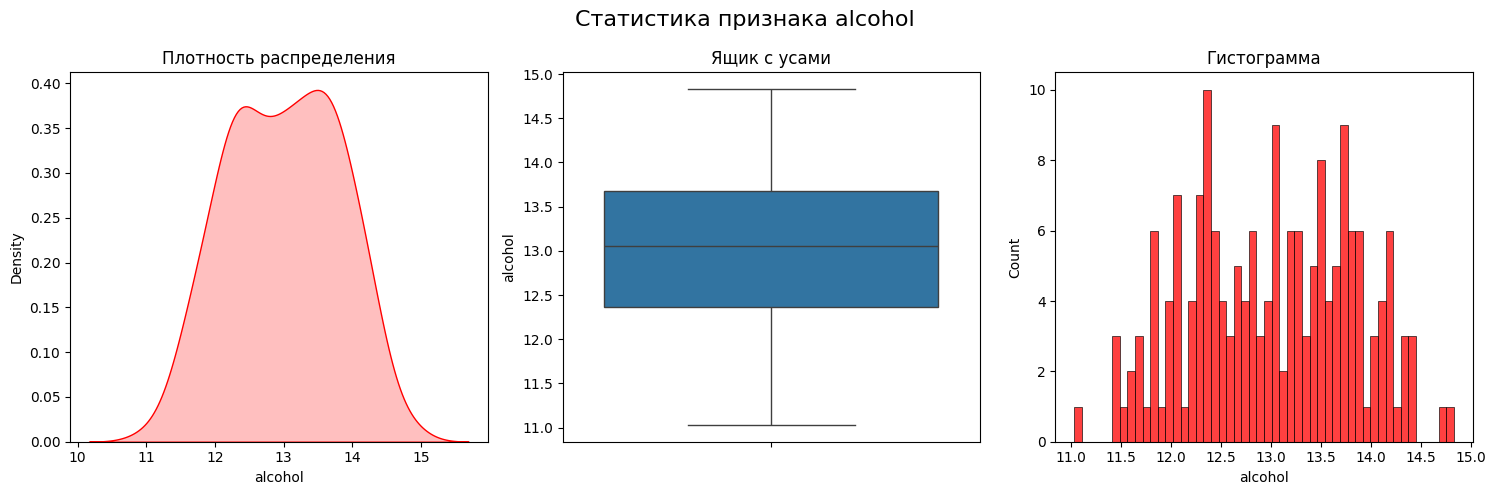

In [70]:
temp = next(names)
plots(df[temp], temp)

<Axes: >

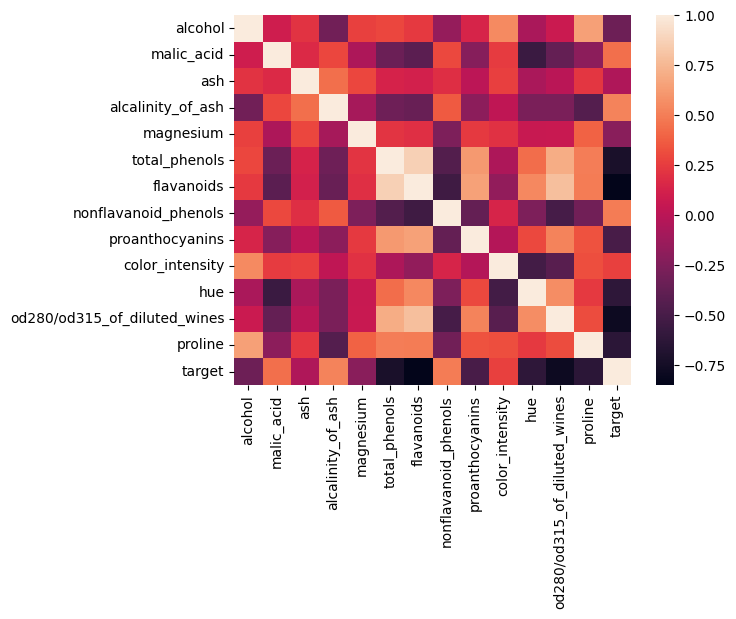

In [129]:
sns.heatmap(df.corr())

In [130]:
df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-130-0890aefbf3d8>:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
alcohol,1.00,0.09,0.21,-0.31,0.27,0.29,0.24,-0.16,0.14,0.55,-0.07,0.07,0.64,-0.33
malic_acid,0.09,1.00,0.16,0.29,-0.05,-0.34,-0.41,0.29,-0.22,0.25,-0.56,-0.37,-0.19,0.44
ash,0.21,0.16,1.00,0.44,0.29,0.13,0.12,0.19,0.01,0.26,-0.07,0.00,0.22,-0.05
alcalinity_of_ash,-0.31,0.29,0.44,1.00,-0.08,-0.32,-0.35,0.36,-0.20,0.02,-0.27,-0.28,-0.44,0.52
magnesium,0.27,-0.05,0.29,-0.08,1.00,0.21,0.20,-0.26,0.24,0.20,0.06,0.07,0.39,-0.21
total_phenols,0.29,-0.34,0.13,-0.32,0.21,1.00,0.86,-0.45,0.61,-0.06,0.43,0.70,0.50,-0.72
flavanoids,0.24,-0.41,0.12,-0.35,0.20,0.86,1.00,-0.54,0.65,-0.17,0.54,0.79,0.49,-0.85
nonflavanoid_phenols,-0.16,0.29,0.19,0.36,-0.26,-0.45,-0.54,1.00,-0.37,0.14,-0.26,-0.50,-0.31,0.49
proanthocyanins,0.14,-0.22,0.01,-0.20,0.24,0.61,0.65,-0.37,1.00,-0.03,0.30,0.52,0.33,-0.50
color_intensity,0.55,0.25,0.26,0.02,0.20,-0.06,-0.17,0.14,-0.03,1.00,-0.52,-0.43,0.32,0.27


In [119]:
y = df['target']
x = df.drop('target', axis=1)

In [120]:
x_train, x_test, y_train, y_test = train_test_split(x, y.to_numpy(), test_size=0.2, shuffle=True)

In [121]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [122]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)#.reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32)#.reshape(-1, 1)

In [123]:
y_test

tensor([2., 2., 2., 2., 1., 0., 2., 1., 2., 0., 0., 0., 1., 1., 1., 0., 1., 2.,
        1., 2., 2., 0., 1., 1., 2., 2., 2., 0., 1., 0., 2., 2., 2., 1., 1., 1.])

In [95]:
class RealDataModel(nn.Module):
    def __init__(self):
        super(RealDataModel, self).__init__()

        self.lay1 = nn.Linear(13, 128)
        self.act1 = nn.ReLU()

        self.lay2 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()

        self.lay3 = nn.Linear(64, 32)
        self.act3 = nn.ReLU()

        self.lay4 = nn.Linear(32, 16)
        self.act4 = nn.ReLU()

        self.lay5 = nn.Linear(16, 8)
        self.act5 = nn.ReLU()

        self.lay6 = nn.Linear(8, 3)

        self.dropout_2 = nn.Dropout(0.2)
        self.dropout_1 = nn.Dropout(0.1)

    def forward(self, x):
        x = self.act1(self.lay1(x))
        x = self.dropout_2(x)
        x = self.act2(self.lay2(x))
        x = self.dropout_2(x)
        x = self.act3(self.lay3(x))
        x = self.dropout_1(x)
        x = self.act4(self.lay4(x))
        x = self.act5(self.lay5(x))
        x = self.lay6(x)
        return x

In [131]:
model_1 = RealDataModel()
model_2 = RealDataModel()
model_3 = RealDataModel()


optims = {
          'Adam' : [optim.Adam(model_1.parameters(), lr=0.0001), model_1],
          'SGD' : [optim.SGD(model_2.parameters(), lr=0.01), model_2],
          'RMSprop' : [optim.RMSprop(model_3.parameters(), lr=0.0001), model_3]
}
loss = nn.CrossEntropyLoss()
loss_list = []
acc_list = []
for opt_name, opt_and_model in optims.items():
    print("Optimizer name: ", opt_name)
    best, losses, accs = train_model(opt_and_model[1], opt_and_model[0], loss, 100, 5,
          x_train, y_train, x_test, y_test)
    print("Best accuracy: ", best)
    loss_list.append(losses)
    acc_list.append(accs)

Optimizer name:  Adam


Epoch 20: 100%|██████████| 29/29 [00:00<00:00, 85.16batch/s, acc=1, loss=0.356]


Best accuracy:  1.0
Optimizer name:  SGD


Epoch 81: 100%|██████████| 29/29 [00:00<00:00, 91.73batch/s, acc=1, loss=0.0563]


Best accuracy:  1.0
Optimizer name:  RMSprop


Epoch 83: 100%|██████████| 29/29 [00:00<00:00, 79.63batch/s, acc=1, loss=0.288]


Best accuracy:  1.0


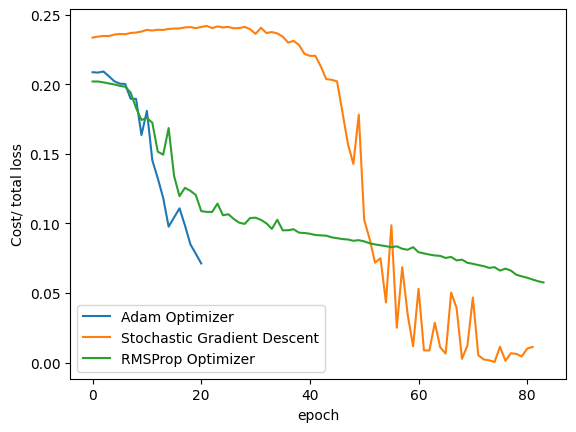

In [132]:
plt.plot(loss_list[0], label = "Adam Optimizer")
plt.plot(loss_list[1], label = "Stochastic Gradient Descent")
plt.plot(loss_list[2], label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

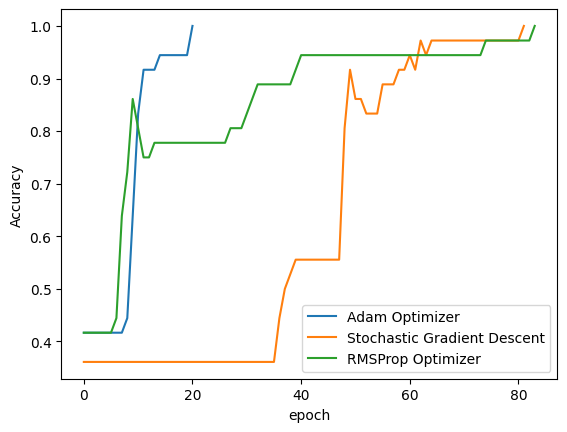

In [133]:
plt.plot(acc_list[0], label = "Adam Optimizer")
plt.plot(acc_list[1], label = "Stochastic Gradient Descent")
plt.plot(acc_list[2], label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()